In [ ]:
!pip install --upgrade wandb

In [ ]:
!pip uninstall -y simglucose
!pip install git+https://github.com/jxx123/simglucose.git


  Cloning https://github.com/jxx123/simglucose.git to /tmp/pip-req-build-iltg8k4e
  Running command git clone --filter=blob:none --quiet https://github.com/jxx123/simglucose.git /tmp/pip-req-build-iltg8k4e
  Resolved https://github.com/jxx123/simglucose.git to commit a6f6777586c860457a2a1e6cce6d0bd3fd33d1cc
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.8/157.8 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.1 MB/s eta 0:00:00
  Created wheel for simglucose: filename=simglucose-

In [ ]:
!rm ~/.netrc
!rm -rf ~/.config/wandb ~/.cache/wandb ~/.netrc 2>/dev/null || true


rm: cannot remove '/root/.netrc': No such file or directory


In [ ]:
import wandb
wandb.finish()
wandb.login(key="d4702dde1e8a1be47e28e72e04efe4611c61dc84", relogin=True)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sayyappr (sayyappr-university-of-michigan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import numpy as np

def extract_rich_state_features(iob, meal, insulin_history, time, bg_history):
    # BG slope from last 5 readings
    cgm_window = bg_history[-5:]
    cgm_window = np.nan_to_num(cgm_window, nan=0.0, posinf=0.0, neginf=0.0)
    slope = np.polyfit(range(len(cgm_window)), cgm_window, 1)[0]

    # IOB (raw)
    iob_raw = iob

    # Meal bin: 0 = no meal, 1 = any meal
    meal_bin = 0 if meal == 0 else 1

    # Time in range (TIR): last 2h window
    tir_window = bg_history[-24:]
    tir_percent = np.sum((np.array(tir_window) >= 70) & (np.array(tir_window) <= 180)) / len(tir_window)
    tir_percent = np.sum((np.array(tir_window) >= 70) & (np.array(tir_window) <= 180)) / len(tir_window)

    if tir_percent < 0.4:
        tir_bin = 0
    elif tir_percent < 0.7:
        tir_bin = 1
    else:
        tir_bin = 2

    return {
        "slope": slope,
        "iob": iob_raw,
        "meal_bin": meal_bin,
        # "last_dose_bin": last_dose_bin,
        "tir_bin": tir_bin
    }


In [ ]:
# agents/meal_loader.py
import pandas as pd
import numpy as np
from scipy.stats import bernoulli, truncnorm, norm

PARAMS = pd.read_csv('/content/vpatient_params.csv', usecols=['Name', 'BW', 'u2ss'])
Q = pd.read_csv('/content/Quest.csv', usecols=['Name', 'CR', 'CF'])

def height_age(weight, kind):
    if kind == 'child':
        data = [(0, 25.6, 7, 121.9), (25.6, 28.6, 8, 128), (28.6, 32, 9, 133.3), (32, 35.6, 10, 138.4), (35.6, 39.9, 11, 143.5), (39.9, np.inf, 12, 149.1)]
    elif kind == 'adolescent':
        data = [(0, 50.8, 13, 156.2), (50.8, 56.0, 14, 163.8), (56.0, 60.8, 15, 170.1), (60.8, 64.4, 16, 173.4), (64.4, 66.9, 17, 175.2), (66.9, 68.9, 18, 175.7), (68.9, 70.3, 19, 176.5), (70.3, np.inf, 20, 177)]
    else:
        return 177, 45
    for lower, upper, age, height in data:
        if lower < weight <= upper:
            return height, age
    return 177, 45

def expected_carbs(w, h, a):
    BMR = 66.5 + (13.75 * w) + (5.003 * h) - (6.755 * a)
    return (BMR * 0.45) / 4

def get_action_scale(patient_id):
    w = PARAMS[PARAMS.Name == patient_id].BW.item()
    u2ss = PARAMS[PARAMS.Name == patient_id].u2ss.item()
    basal = u2ss * w / 6000
    cr = Q[Q.Name == patient_id].CR.item()
    cf = Q[Q.Name == patient_id].CF.item()
    max_cho = expected_carbs(w, *height_age(w, patient_id[:-4])) * 0.35 * 1.2
    max_bolus = (max_cho / cr) + (400 - 140) / cf
    return basal, max_bolus / 5

def simple_meal_gen(w, h, a, n, seed=0):
    np.random.seed(seed)
    expected = expected_carbs(w, h, a)
    occ = [0.95, 0.95, 0.95]
    bounds = [(5, 9), (10, 14), (16, 20)]
    means = [7, 12, 18]
    meal_means = [0.333, 0.333, 0.334]
    scen = []
    for day in range(n):
        for i, (lb, ub) in enumerate(bounds):
            if bernoulli.rvs(occ[i]):
                t = round(truncnorm.rvs((lb - means[i]) / 1, (ub - means[i]) / 1, loc=means[i], scale=1) * 60) + 1440 * day
                c = round(max(0, norm.rvs(loc=meal_means[i] * expected * 1.2, scale=0.15 * meal_means[i] * expected)))
                scen.append((t, c))
    return scen

def patient_scenario(patient_id, n_days=2, seed=0):
    w = PARAMS[PARAMS.Name == patient_id].BW.item()
    h, a = height_age(w, patient_id[:-4])
    return simple_meal_gen(w, h, a, n_days, seed)


In [ ]:
# utils/bin_definitions.py
import pandas as pd
#from agents.meal_loader import get_action_scale


def get_action_bins(patient_id):
    min_dose, max_dose = get_action_scale(patient_id)
    return min_dose, max_dose

def discretize_rich_state(state):
    # Discretize slope
    if state["slope"] < -5:
        slope_bin = 0
    elif state["slope"] < 0:
        slope_bin = 1
    elif state["slope"] < 5:
        slope_bin = 2
    else:
        slope_bin = 3

    # Discretize IOB
    iob = state["iob"]
    if iob == 0:
        iob_bin = 0
    elif iob <= 2:
        iob_bin = 1
    elif iob <= 4:
        iob_bin = 2
    else:
        iob_bin = 3

    return (
        iob_bin,             # 4 bins
        state["meal_bin"],   # 2 bins
        slope_bin,           # 4 bins
        state["tir_bin"]     # 3 bins
    )



In [ ]:

class BGLogger:
    def __init__(self):
        self.bg_values = []

    def record(self, info):
        if "bg" in info:
            self.bg_values.append(float(info["bg"]))

    def count_hypo(self):
        return sum(1 for x in self.bg_values if x < 70)

    def percent_safe_range(self):
        if not self.bg_values:
            return 0.0
        safe = sum(1 for x in self.bg_values if 70 <= x <= 180)
        return 100.0 * safe / len(self.bg_values)

    def reset(self):
        self.bg_values = []


class EpisodeLogger:
    def __init__(self):
        self.episodes = []

    def start_episode(self):
        self.current = {
            "bg": [],
            "insulin": [],
            "cho": [],
            "is_meal": [],
            "action": []
        }

    def record_step(self, info, insulin, cho, action):
        self.current["bg"].append(info["bg"])
        self.current["insulin"].append(insulin)
        self.current["cho"].append(cho)
        self.current["is_meal"].append(cho > 0)
        self.current["action"].append(action)

    def end_episode(self):
        self.episodes.append(self.current)

    def get_samples(self):
        if len(self.episodes) < 3:
            return self.episodes
        return [
            self.episodes[0],
            self.episodes[len(self.episodes) // 2],
            self.episodes[-1],
        ]




In [ ]:
# agents/q_learning_agent.py
import numpy as np
from collections import defaultdict

class QLearningAgent:
    def __init__(self, action_space, gamma=0.9, alpha=0.1, epsilon=0.1):
        self.action_space = action_space
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: np.full(len(action_space), -100.0))

    def select_action(self, state_idx):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_space)
        q_vals = self.q_table[state_idx]
        return self.action_space[np.argmax(q_vals)]


    def update(self, state_idx, action_val, reward, next_state_idx=None, done=False):
        a_idx_candidates = np.where(np.isclose(self.action_space, action_val, atol=1e-4))[0]
        if len(a_idx_candidates) == 0:
            raise ValueError(f"Action {action_val} not in action space {self.action_space}")
        
        a_idx = np.where(self.action_space == action_val)[0][0]

        if done or next_state_idx is None:
            td_target = reward
        else:
            next_max = np.max(self.q_table[next_state_idx])
            td_target = reward + self.gamma * next_max

        td_error = td_target - self.q_table[state_idx][a_idx]
        self.q_table[state_idx][a_idx] += self.alpha * td_error



In [ ]:
from simglucose.analysis.risk import risk_index

def full_risk_index_reward(bg_series, horizon):
    if len(bg_series) < horizon:
        return 0
    _, _, RI = risk_index(bg_series[-horizon:], horizon)
    return -RI


In [ ]:
from collections import defaultdict, Counter

state_bin_counter = Counter()
state_action_counter = defaultdict(Counter)


In [ ]:
import numpy as np
import wandb
from datetime import datetime
from simglucose.controller.base import Action
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.simulation.env import T1DSimEnv
from collections import deque
import time

GAMMA_VALUES = [0.95]
MAX_STEPS=2500

for gamma_val in GAMMA_VALUES:
    run = wandb.init(
        project="simglucose-tabular-rl_updated_states_randomScen",
        name=f"adult-gamma-{gamma_val}-{datetime.now().strftime('%H%M')}",
        config={
            "gamma": gamma_val,
            "episodes": 1000,
            "patient_id": "adult#001",
            "state_config": "[GlucoseTrend, IOB_bin, Meal_bin, TIR_bin]",
            "action_bins": 5,
            "epsilon_start": 1.0,
            "epsilon_end": 0.05,
            "epsilon_decay": 0.99,
            "reward_horizon": 12
        },
        reinit=True
    )

    config = wandb.config
    epsilon = config.epsilon_start

    patient = T1DPatient.withName(config.patient_id)
    sensor = CGMSensor.withName("Dexcom")
    pump = InsulinPump.withName("Insulet")




    meal_scen = RandomScenario(
        start_time=datetime.now(),
        seed=42
    )


    env = T1DSimEnv(patient=patient, sensor=sensor, pump=pump, scenario=meal_scen)
    env.sample_time = 5
    # env.max_time = 7 * 24 * 60

    min_dose, max_dose = get_action_bins(config.patient_id)
    # action_bins = np.linspace(min_dose, max_dose, config.action_bins)
    # action_bins = np.unique(np.append(np.linspace(min_dose, max_dose, config.action_bins), 0.0))
    action_bins = np.insert(np.linspace(min_dose, max_dose, config.action_bins - 1), 0, 0.0)
    agent = QLearningAgent(action_space=action_bins, gamma=config.gamma)

    smoothed_rewards = deque(maxlen=10)
    logger = BGLogger()

    steps_count = 0

    visited_states = set()
    total_possible_states = 96

    all_bg_per_episode = []
    all_cgm_per_episode = []
    all_meal_per_episode = []
    all_insulin_per_episode = []

    all_meal_flags = []
    all_insulin_vals = []
    all_exploration_flags = []



    all_discretized_states = []

    all_meal_event_snapshots = []


    for episode in range(config.episodes):
        print(f"Episode {episode}")
        step_result = env.reset()
        obs = step_result.observation
        info = step_result.info

        print(step_result)

        reward_window = deque(maxlen=20)

        


        done = False
        total_reward = 0
        step_rewards = []
        cgm_history = []
        bg_history = []
        insulin_history = []
        time_minute = 0
        action_val = 0

        episode_step_count = 0

        last_meal = 0.0  

        post_meal_rewards = []         
        meal_tracking_counter = 0     
        current_post_meal = []         

        bg_tracking = []
        meal_tracking = []
        insulin_tracking = []

        bg_tracking = []
        cgm_tracking = []
        meal_tracking = []

        meal_flags = []
        insulin_vals = []
        exploration_flags = []

        meal_event_snapshots = []

        while not done:
            episode_step_count += 1
            steps_count += 1

            

            cgm = obs.CGM
            bg = info['bg']
            meal = info['meal']
            iob = info['patient_state'][5]
            


            

            cgm_history.append(cgm)
            
            if len(cgm_history) < 5:
                cgm_history = [cgm] * 5
            if len(bg_history) < 5:
                bg_history = [bg] * 5

            state = extract_rich_state_features(
                # cgm_history=cgm_history,
                iob=iob,
                meal=meal,
                insulin_history=insulin_history,
                time=time_minute,
                bg_history=bg_history
            )
            state_idx = discretize_rich_state(state)


            visited_states.add(state_idx)

            all_discretized_states.append(state_idx)

            # state_bin_counter[state_idx] += 1
            # state_action_counter[state_idx][action_val] += 1

            meal_start = meal > 0

            if meal_start:
              if np.random.rand() < epsilon:
                  action_val = np.random.choice(action_bins)
                  action_type = 'explore'
              else:
                  action_val = agent.select_action(state_idx)
                  action_type = 'exploit'
            else:
                action_val = 0.0
                action_type = 'no_meal'

                        
            meal_event = (meal > 0)
            bolused    = (action_val > 0.0)

            if meal_event and bolused:
                iob_bin, meal_bin, slope_bin, tir_bin = state_idx  # unpack bins

                meal_event_snapshots.append({
                    "episode": episode,
                    "step": episode_step_count,
                    "time_min": time_minute,
                    "bg": bg,
                    "cho": meal,
                    "insulin": action_val,
                    "iob_bin": iob_bin,
                    "slope_bin": slope_bin,
                    "tir_bin": tir_bin
                })


            # Log
            meal_flags.append(meal_start)
            insulin_vals.append(action_val)
            exploration_flags.append(action_type)

            
            a_idx = int(np.argmin(np.abs(action_bins - action_val)))  # 0..NUM_ACTIONS-1

        

            def _valid_state_tuple(s):
              try:
                  iob, meal, slope, tir = s
                  return (0 <= iob <= 3) and (0 <= meal <= 1) and (0 <= slope <= 3) and (0 <= tir <= 2)
              except Exception:
                  return False

            if action_val > 0.0 and _valid_state_tuple(state_idx):
                state_bin_counter[state_idx] += 1
                state_action_counter[state_idx][a_idx] += 1


            action = Action(basal=0, bolus=action_val)
            step_result = env.step(action)
            obs = step_result.observation
            env_done = step_result.done
            info = step_result.info

            # bg_tracking.append(obs.CGM)
            # meal_tracking.append(info['meal'])
            insulin_tracking.append(action_val)

            # bg_tracking.append(bg)
            # meal_tracking.append(meal)

            cgm_tracking.append(obs.CGM)
            new_bg = info['bg']
            bg_history.append(new_bg)         
            bg_tracking.append(new_bg)
            meal_tracking.append(info['meal'])



            bg_window = bg_history[-config.reward_horizon:]
            reward = full_risk_index_reward(bg_window, horizon=config.reward_horizon)


            

                        
            time_limit = (episode_step_count >= MAX_STEPS)
            terminal   = env_done or time_limit

            if env_done and not time_limit:
                worst_step = 100.0
                alpha      = 1.2
                remaining  = MAX_STEPS - episode_step_count
                if remaining > 0:
                    reward += -alpha * worst_step * remaining  

            step_rewards.append(reward)


            if meal_start:
                meal_tracking_counter = 20
                current_post_meal = []

            if meal_tracking_counter > 0:
                current_post_meal.append(reward)
                meal_tracking_counter -= 1

                if meal_tracking_counter == 0 and len(current_post_meal) == 20:
                    post_meal_rewards.append(np.mean(current_post_meal))

            if post_meal_rewards:
              wandb.log({
                  "avg_reward_20_steps_post_meal": np.mean(post_meal_rewards),
                  "meals_detected": len(post_meal_rewards)
              })


            reward_window.append(reward)
            if len(reward_window) == 20:
                wandb.log({"avg_reward_last_20_steps": sum(reward_window)/20})

            log_dict = {
                "step_reward": reward,
                "bg": new_bg,
                "episode": episode,
                "step": episode_step_count
            }

            if len(bg_window) >= config.reward_horizon:
                # LBGI, HBGI, RI = risk_index(bg_window[-config.reward_horizon:], config.reward_horizon)
                LBGI, HBGI, RI = risk_index(bg_window, config.reward_horizon)
                log_dict.update({
                    "LBGI": LBGI,
                    "HBGI": HBGI,
                    "RI": RI
                })

            # Add per-step max Q-value
            # max_q_step = max(np.max(q_vals) for q_vals in agent.q_table.values())
            if agent.q_table:
                max_q_step = max(np.max(q_vals) for q_vals in agent.q_table.values())
            else:
                max_q_step = float('-inf')  # or 0.0 if you prefer

            log_dict.update({
                  "max_q_step": max_q_step
      })

            wandb.log(log_dict)

            total_reward += reward
            insulin_history.append(action_val)

            next_state = extract_rich_state_features(
                # cgm_history=cgm_history,
                iob=info['patient_state'][5],
                meal=info['meal'],
                insulin_history=insulin_history,
                time=time_minute + 5,
                bg_history=bg_history
            )
            next_idx = discretize_rich_state(next_state)

            agent.update(state_idx, action_val, reward, next_idx, done = terminal)
            logger.record(info)
            time_minute += 5
            done = terminal

        smoothed_rewards.append(total_reward)

        wandb.log({
            "episode": episode,
            "steps_per_episode": episode_step_count,
            "total_reward": total_reward,
            "avg_step_reward": np.mean(step_rewards),
            "min_step_reward": np.min(step_rewards),
            "max_step_reward": np.max(step_rewards),
            "smoothed_reward": np.mean(smoothed_rewards),
            # "max_q_value": max(np.max(q_vals) for q_vals in agent.q_table.values()),
            "max_q_value": (
                max(np.max(q_vals) for q_vals in agent.q_table.values())
                if agent.q_table else float('-inf')
            ),
            "hypoglycemia_events": logger.count_hypo(),
            "tir_percent": logger.percent_safe_range(),
            "reward_horizon": config.reward_horizon,
            "epsilon": epsilon,
            "meal_present": meal > 0,
            "action_taken": action_val
        })

        print(f"Episode {episode}: Total Reward = {total_reward:.2f}, Min Step Reward = {np.min(step_rewards):.2f}, Max Step Reward = {np.max(step_rewards):.2f}")
        print(f"[DEBUG] BG: {obs.CGM:.2f}, Step Reward: {reward:.2f}")
        print("Step Rewards:", step_rewards)
        print("Max:", max(step_rewards), "Min:", min(step_rewards))

        visited_percent = len(visited_states) / total_possible_states * 100
        wandb.log({
            "visited_state_percent": visited_percent
        })

        print(f"[DEBUG] Visited states: {len(visited_states)} / {total_possible_states} ({visited_percent:.2f}%)")

        all_meal_event_snapshots.append(meal_event_snapshots)  

        epsilon = max(config.epsilon_end, epsilon * config.epsilon_decay)

        logger.reset()

        if len(step_rewards) >= 20:
          rolling_avg = np.convolve(step_rewards, np.ones(20)/20, mode='valid')
          wandb.log({
              "avg_rolling_20_reward_episode": np.mean(rolling_avg)
          })

        all_bg_per_episode.append(bg_tracking)
        all_cgm_per_episode.append(cgm_tracking)
        all_meal_per_episode.append(meal_tracking)
        all_insulin_per_episode.append(insulin_history)

        all_meal_flags.append(meal_flags)
        all_insulin_vals.append(insulin_vals)
        all_exploration_flags.append(exploration_flags)


    print(f"Finished gamma {gamma_val}")
    wandb.finish()



print("All gamma experiments complete.")


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Episode 0
Step(observation=Observation(CGM=np.float64(161.49740854843606)), reward=0, done=False, info={'sample_time': np.float64(3.0), 'patient_name': 'adult#001', 'meal': 0, 'patient_state': array([  0.        ,   0.        ,   0.        , 265.370112  ,
       162.45709727,   5.5043265 ,   0.        , 100.25      ,
       100.25      ,   3.20762505,  72.43417623, 141.15377933,
       265.370112  ]), 'time': datetime.datetime(2025, 9, 4, 18, 15, 3, 626022), 'bg': np.float64(138.56), 'lbgi': np.float64(0.0), 'hbgi': np.float64(1.5109019799034997), 'risk': np.float64(1.5109019799034997)})
Episode 0: Total Reward = -188006.00, Min Step Reward = -170740.00, Max Step Reward = 0.00
[DEBUG] BG: 39.00, Step Reward: -170740.00
Step Rewards: [0, 0, 0, 0, 0, 0, np.float64(-1.5109226758742267), np.float64(-1.5109475810842803), np.float64(-1.5109927666131355), np.float64(-1.5110688592560166), np.float64(-1.5111896019275426), np.float64(-1.5113721320367457), np.float64(-1.5116372016507793), np.floa

KeyboardInterrupt: 

In [ ]:


import pickle
import os


save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)


timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
base_name = f"gamma_{gamma_val}_{timestamp}"

# Save Q-table
with open(f"{save_dir}/q_table_{base_name}.pkl", "wb") as f:
    pickle.dump(dict(agent.q_table), f)

# Save state-action counter
with open(f"{save_dir}/state_action_counter_{base_name}.pkl", "wb") as f:
    pickle.dump(dict(state_action_counter), f)

# Save visited states and other flags
data_to_save = {
    "visited_states": visited_states,
    "all_discretized_states": all_discretized_states,
    "all_meal_flags": all_meal_flags,
    "all_insulin_vals": all_insulin_vals,
    "all_exploration_flags": all_exploration_flags,
    "all_bg_per_episode": all_bg_per_episode,
    "all_cgm_per_episode": all_cgm_per_episode,
    "all_meal_per_episode": all_meal_per_episode,
    "all_insulin_per_episode": all_insulin_per_episode,
    "meal_event_snapshots": meal_event_snapshots,
    "all_meal_event_snapshots": all_meal_event_snapshots,
}

with open(f"{save_dir}/training_data_{base_name}.pkl", "wb") as f:
    pickle.dump(data_to_save, f)

print(f"Saved Q-table, state-action counts, and training flags under {save_dir}/")



✅ Saved Q-table, state-action counts, and training flags under saved_models/


In [ ]:
with open("/content/saved_models/training_data_gamma_0.95_20250902_053538.pkl", "rb") as f:
    q_table = pickle.load(f)

agent = QLearningAgent(action_space=action_bins, gamma=0.95)
agent.q_table = q_table  


FileNotFoundError: [Errno 2] No such file or directory: '/content/saved_models/training_data_gamma_0.95_20250902_053538.pkl'

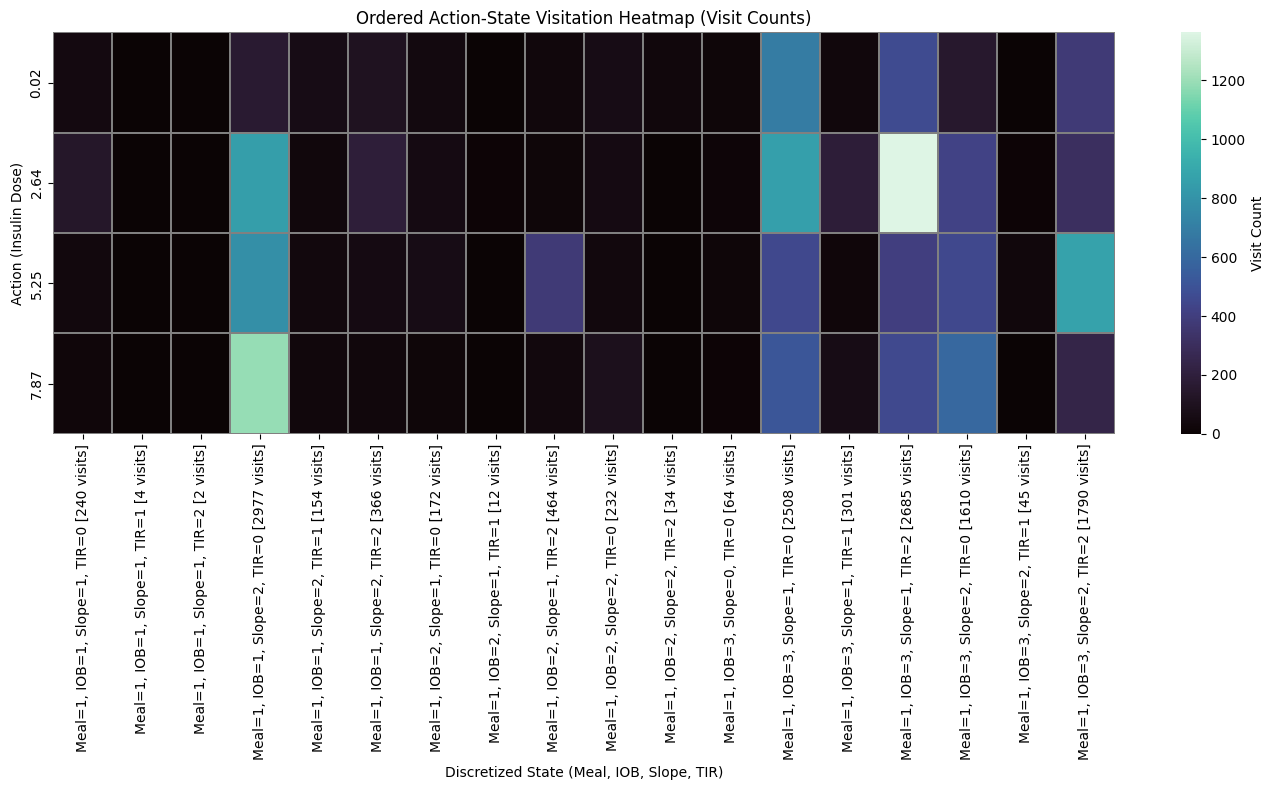

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def _state_label(st, total):
    iob, meal, slope, tir = st
    return f"Meal={meal}, IOB={iob}, Slope={slope}, TIR={tir} [{total} visits]"

def _sort_key(st):
    iob, meal, slope, tir = st
    
    return (meal, iob, slope, tir)

def build_df_counts(state_action_counter, action_bins, include_zero=False):
    A = len(action_bins)
    aidx = list(range(A))
    if not include_zero and np.isclose(action_bins[0], 0.0):
        aidx = aidx[1:]

    counted_states = [s for s,cnts in state_action_counter.items() if sum(cnts.values()) > 0]
    if not counted_states or not aidx:
        raise ValueError("Nothing to plot (no counted states or no action indices).")

    counted_states.sort(key=_sort_key)

    rows, labels = [], []
    for s in counted_states:
        counts = [int(state_action_counter[s].get(i, 0)) for i in aidx]
        total = int(sum(counts))
        rows.append(counts)
        labels.append(_state_label(s, total))

    df = pd.DataFrame(rows, index=labels, columns=[f"{action_bins[i]:.2f}" for i in aidx])
    return df


df_counts = build_df_counts(state_action_counter, action_bins, include_zero=False)

plt.figure(figsize=(max(14, df_counts.shape[0] * 0.35), 8))
sns.heatmap(
    df_counts.T,
    cmap="mako",
    cbar_kws={'label': 'Visit Count'},
    linewidths=0.2,
    linecolor='gray'
)
plt.title("Ordered Action-State Visitation Heatmap (Visit Counts)")
plt.ylabel("Action (Insulin Dose)")
plt.xlabel("Discretized State (Meal, IOB, Slope, TIR)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


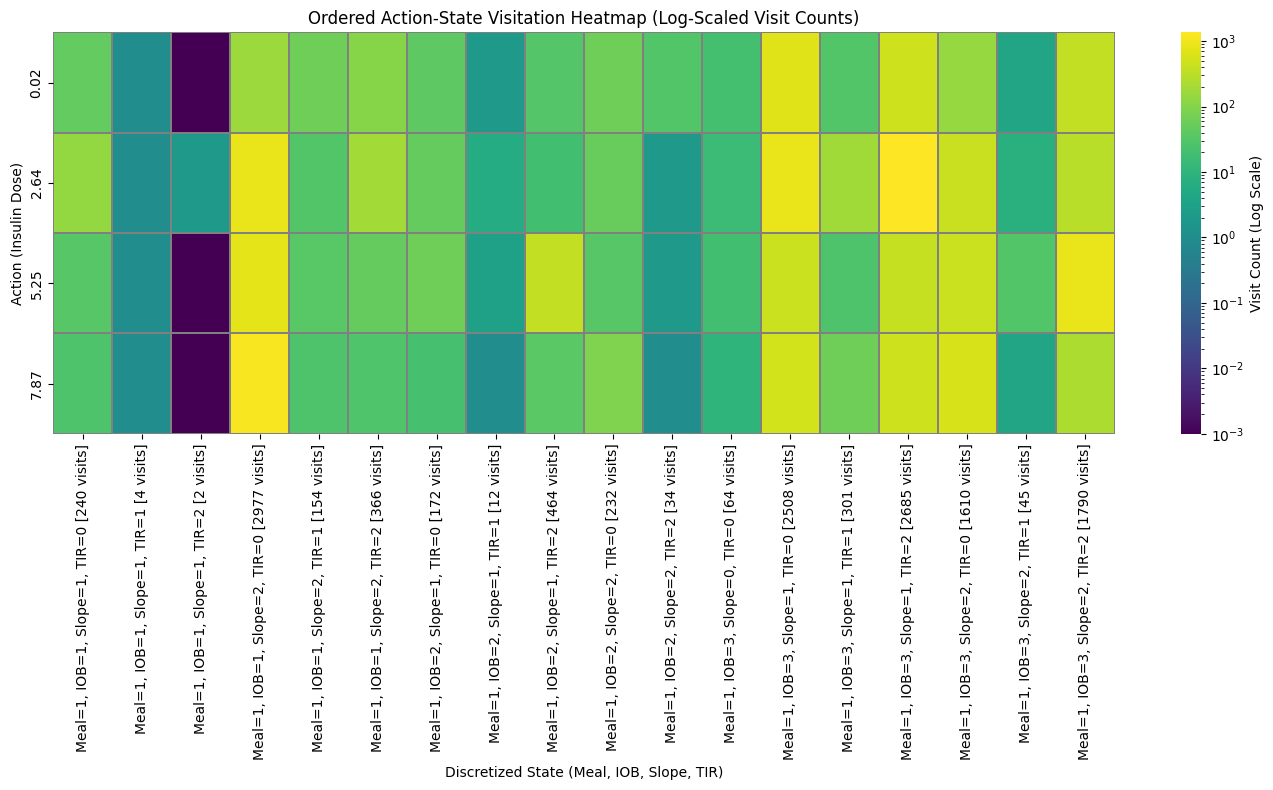

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

df_counts = build_df_counts(state_action_counter, action_bins, include_zero=False)


eps = 1e-3
log_df = df_counts.astype(float) + eps
vmin = eps
vmax = float(np.nanmax(log_df.values))
if not np.isfinite(vmax) or vmax <= vmin:
    vmax = vmin * 10.0

plt.figure(figsize=(max(14, log_df.shape[0] * 0.35), 8))
sns.heatmap(
    log_df.T,
    cmap="viridis",                
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cbar_kws={'label': 'Visit Count (Log Scale)'},
    linewidths=0.2,
    linecolor='gray'
)
plt.title("Ordered Action-State Visitation Heatmap (Log-Scaled Visit Counts)")
plt.ylabel("Action (Insulin Dose)")
plt.xlabel("Discretized State (Meal, IOB, Slope, TIR)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def _stack_trim(list_of_lists, L):
    """Trim each sequence to length L and stack (drop sequences < L)."""
    arrs = []
    for seq in list_of_lists:
        if len(seq) >= L:
            arrs.append(np.asarray(seq[:L], dtype=float))
    if len(arrs) == 0:
        return np.empty((0, L))
    return np.vstack(arrs)

def plot_bg_meal_insulin(
    all_bg_per_episode,
    all_meal_per_episode,
    all_insulin_per_episode,
    sample_minutes=5,
    start_clock="06:00",        
    max_overlay=40              
):
   
    min_len_bg    = min(len(ep) for ep in all_bg_per_episode)    if all_bg_per_episode    else 0
    min_len_meal  = min(len(ep) for ep in all_meal_per_episode)  if all_meal_per_episode  else 0
    min_len_ins   = min(len(ep) for ep in all_insulin_per_episode) if all_insulin_per_episode else 0
    L = int(min(min_len_bg, min_len_meal, min_len_ins))
    if L <= 0:
        raise ValueError("No data to plot (check your per-episode arrays).")

    BG   = _stack_trim(all_bg_per_episode, L)
    MEAL = _stack_trim(all_meal_per_episode, L)      
    INS  = _stack_trim(all_insulin_per_episode, L)  

    
    MEAL = MEAL * sample_minutes

    
    
    t0 = pd.Timestamp(f"2025-01-01 {start_clock}")
    dt = pd.to_timedelta(sample_minutes, unit="m")
    time_index = pd.date_range(t0, periods=L, freq=dt)

    
    bg_mean = BG.mean(axis=0) if BG.size else np.zeros(L)
    bg_std  = BG.std(axis=0)  if BG.size else np.zeros(L)

    
    fig, (ax_bg, ax_meal, ax_ins) = plt.subplots(
        3, 1, figsize=(12, 9), sharex=True, gridspec_kw={'hspace': 0.15}
    )

    
    for row in BG[:max_overlay]:
        ax_bg.plot(time_index, row, color='0.75', linewidth=1, alpha=0.35, zorder=1)
    
    ax_bg.plot(time_index, bg_mean, color='C0', linewidth=2, label="Mean Curve", zorder=3)
    ax_bg.fill_between(time_index, bg_mean-bg_std, bg_mean+bg_std,
                       color='C0', alpha=0.25, label="± 1*std", zorder=2)
    
    ax_bg.axhline(70,  color='tab:green', linestyle='--', linewidth=1.2, label="Hypoglycemia")
    ax_bg.axhline(180, color='tab:red',   linestyle='--', linewidth=1.2, label="Hyperglycemia")
    ax_bg.set_ylabel("Blood Glucose (mg/dL)")
    ax_bg.legend(loc="upper right")
    ax_bg.grid(True, axis='y', alpha=0.2)

    
    bar_width = (dt / pd.Timedelta(days=1))  
    for i, row in enumerate(MEAL[:max_overlay]):
        ax_meal.bar(time_index, row, width=bar_width, alpha=0.35, color='teal', edgecolor='none')
    
    meal_mean = MEAL.mean(axis=0) if MEAL.size else np.zeros(L)
    ax_meal.bar(time_index, meal_mean, width=bar_width, alpha=0.6, color='teal', edgecolor='none', label="Mean CHO")
    ax_meal.set_ylabel("CHO (g)")
    ax_meal.grid(True, axis='y', alpha=0.2)
    ax_meal.legend(loc="upper right")

    
    for i, row in enumerate(INS[:max_overlay]):
        ax_ins.bar(time_index, row, width=bar_width, alpha=0.35, color='purple', edgecolor='none')
    ins_mean = INS.mean(axis=0) if INS.size else np.zeros(L)
    ax_ins.bar(time_index, ins_mean, width=bar_width, alpha=0.6, color='purple', edgecolor='none', label="Mean Insulin")
    ax_ins.set_ylabel("Insulin (U)")
    ax_ins.grid(True, axis='y', alpha=0.2)
    ax_ins.legend(loc="upper right")

    
    ax_ins.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    for ax in (ax_bg, ax_meal, ax_ins):
        ax.set_xlim(time_index[0], time_index[-1])

    plt.xlabel(time_index[0].strftime('%b %d')) 
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-4197442264.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


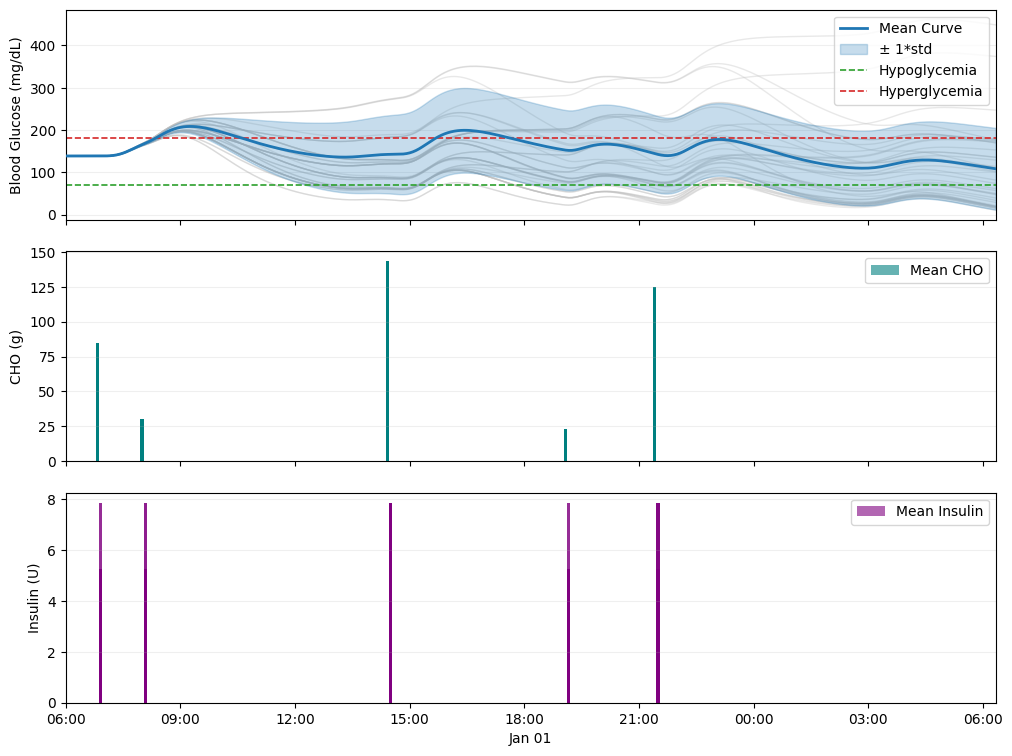

In [ ]:
plot_bg_meal_insulin(
    all_bg_per_episode=all_bg_per_episode,
    all_meal_per_episode=all_meal_per_episode,
    all_insulin_per_episode=all_insulin_per_episode,
    sample_minutes=5,          
    start_clock="06:00",       
    max_overlay=40             
)




/tmp/ipython-input-4197442264.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


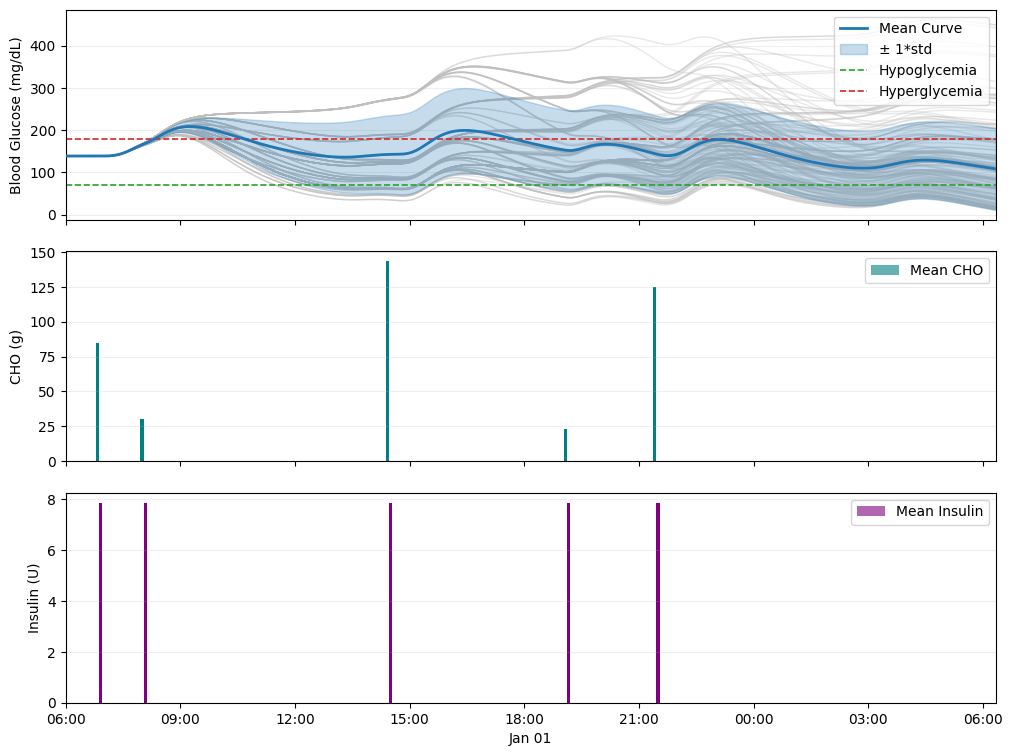

In [ ]:

plot_bg_meal_insulin(
    all_bg_per_episode, all_meal_per_episode, all_insulin_per_episode,
    sample_minutes=5, start_clock="06:00", max_overlay=200  
)


/tmp/ipython-input-3608878603.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


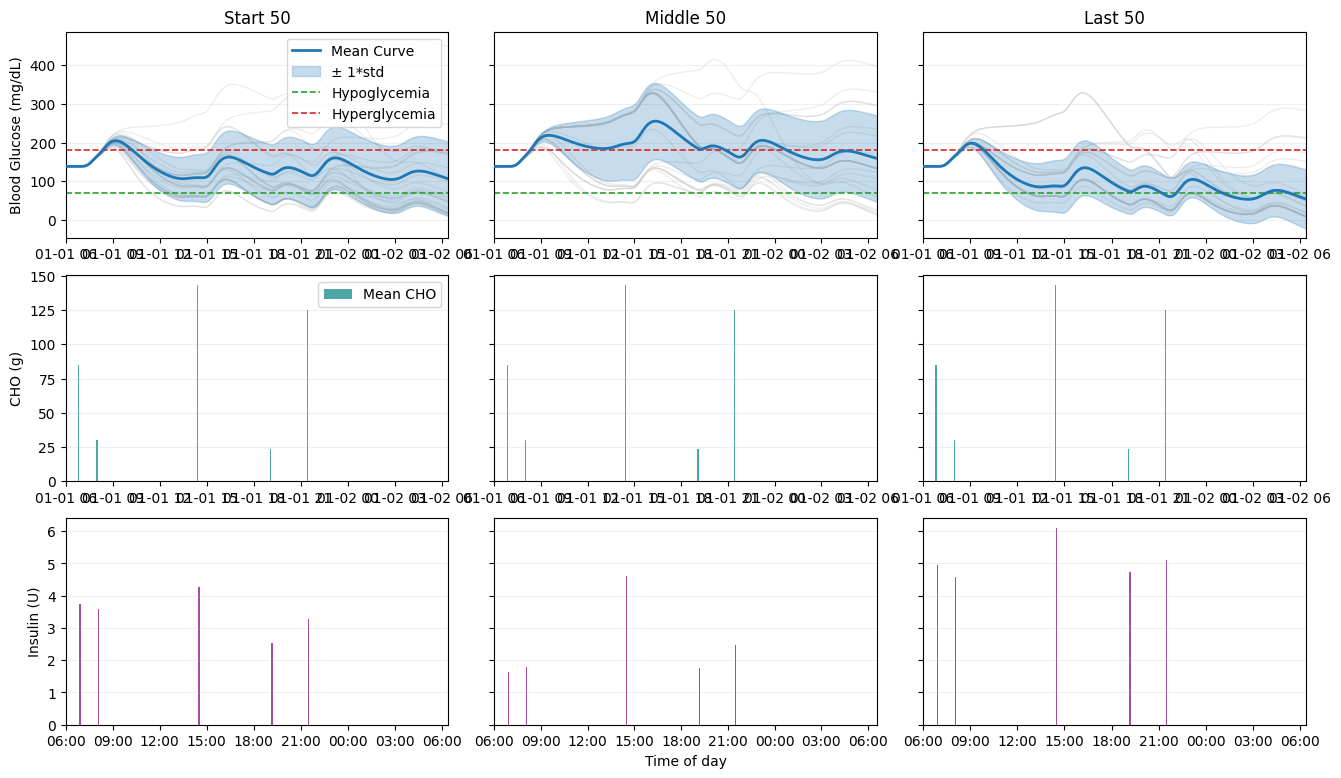

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def _stack_trim(list_of_lists, L):
    arrs = []
    for seq in list_of_lists:
        if len(seq) >= L:
            arrs.append(np.asarray(seq[:L], dtype=float))
    return np.vstack(arrs) if arrs else np.empty((0, L))

def _pick_windows(E, k):
    k = min(k, E)
    start = list(range(0, k))
    mid0 = max(E//2 - k//2, 0); mid1 = min(mid0 + k, E)
    middle = list(range(mid0, mid1))
    last = list(range(max(E-k, 0), E))
    return [start, middle, last], ["Start 50", "Middle 50", "Last 50"]

def plot_time_aligned_windows(all_bg, all_meal, all_ins, sample_minutes=5,
                              start_clock="06:00", window_size=50,
                              overlay_each=30):
    E = min(len(all_bg), len(all_meal), len(all_ins))
    if E == 0:
        raise ValueError("No episodes to plot.")
    windows, titles = _pick_windows(E, window_size)

    fig, axs = plt.subplots(3, 3, figsize=(16, 9), sharex=False, sharey='row',
                            gridspec_kw={'hspace': 0.18, 'wspace': 0.12})

    for col, (win, title) in enumerate(zip(windows, titles)):
        
        L = min(min(len(all_bg[i]) for i in win),
                min(len(all_meal[i]) for i in win),
                min(len(all_ins[i]) for i in win))
        if L <= 0:  
            for r in range(3): axs[r, col].set_visible(False)
            continue

        BG   = _stack_trim([all_bg[i]   for i in win], L)
        MEAL = _stack_trim([all_meal[i] for i in win], L) * sample_minutes 
        INS  = _stack_trim([all_ins[i]  for i in win], L)

        
        t0 = pd.Timestamp(f"2025-01-01 {start_clock}")
        dt = pd.to_timedelta(sample_minutes, unit="m")
        t  = pd.date_range(t0, periods=L, freq=dt)
        barw = (dt / pd.Timedelta(days=1)) 

        
        ax = axs[0, col]
        for row in BG[:overlay_each]:
            ax.plot(t, row, color='0.80', lw=1, alpha=0.35, zorder=1)
        mu, sd = BG.mean(axis=0), BG.std(axis=0)
        ax.plot(t, mu, color='C0', lw=2, label="Mean Curve", zorder=3)
        ax.fill_between(t, mu-sd, mu+sd, color='C0', alpha=0.25, label="± 1*std", zorder=2)
        ax.axhline(70,  ls='--', c='tab:green', lw=1.2, label="Hypoglycemia")
        ax.axhline(180, ls='--', c='tab:red',   lw=1.2, label="Hyperglycemia")
        if col == 0: ax.set_ylabel("Blood Glucose (mg/dL)")
        ax.set_title(title)
        ax.grid(True, axis='y', alpha=0.2)
        if col == 0: ax.legend(loc="upper right")

        
        ax = axs[1, col]
        ax.bar(t, MEAL.mean(axis=0), width=barw, color='teal', alpha=0.7, label="Mean CHO")
        if col == 0: ax.set_ylabel("CHO (g)")
        ax.grid(True, axis='y', alpha=0.2)
        if col == 0: ax.legend(loc="upper right")

        
        ax = axs[2, col]
        ax.bar(t, INS.mean(axis=0), width=barw, color='purple', alpha=0.7, label="Mean Insulin")
        if col == 0: ax.set_ylabel("Insulin (U)")
        ax.grid(True, axis='y', alpha=0.2)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        if col == 1: ax.set_xlabel("Time of day")

        
        for r in range(3):
            axs[r, col].set_xlim(t[0], t[-1])

    plt.tight_layout()
    plt.show()

plot_time_aligned_windows(
    all_bg_per_episode, all_meal_per_episode, all_insulin_per_episode,
    sample_minutes=5, start_clock="06:00", window_size=50, overlay_each=25
)


/tmp/ipython-input-2659571709.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


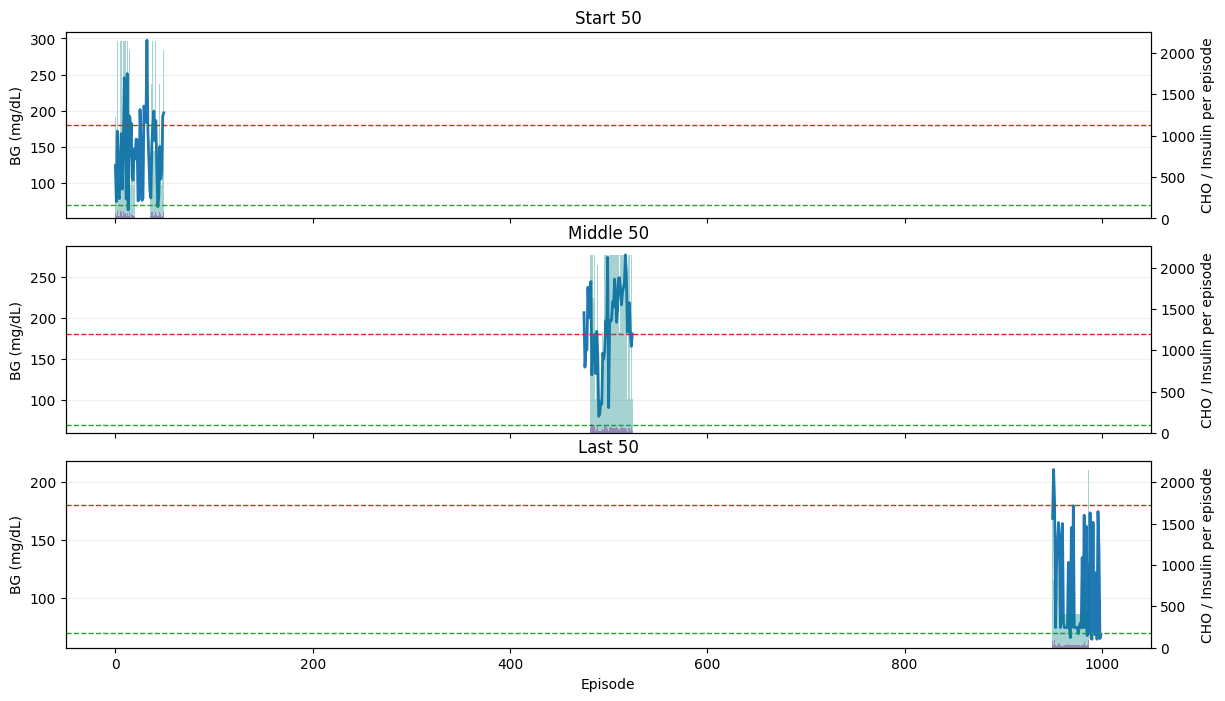

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_episode_windows(all_bg, all_meal, all_ins, sample_minutes=5, window_size=50):
    E = min(len(all_bg), len(all_meal), len(all_ins))
    if E == 0: raise ValueError("No episodes to plot.")
    windows, titles = _pick_windows(E, window_size)

    fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True, gridspec_kw={'hspace': 0.15})

    
    def agg_bg(ep):
        arr = np.asarray(all_bg[ep])
        return np.nanmean(arr) if arr.size else np.nan

    def agg_cho(ep):
        return float(np.sum(all_meal[ep]) * sample_minutes) if len(all_meal[ep]) else 0.0

    def agg_ins(ep):
        return float(np.sum(all_ins[ep])) if len(all_ins[ep]) else 0.0

    for ax, (win, title) in zip(axes, zip(windows, titles)):
        ep_idx = np.array(win)
        mean_bg   = np.array([agg_bg(i)  for i in ep_idx])
        cho_total = np.array([agg_cho(i) for i in ep_idx])
        ins_total = np.array([agg_ins(i) for i in ep_idx])

        ax2 = ax.twinx()
        ax.plot(ep_idx, mean_bg, lw=2, label="Mean BG", color='C0')
        ax.axhline(70,  ls='--', c='tab:green', lw=1)
        ax.axhline(180, ls='--', c='tab:red',   lw=1)
        ax.set_ylabel("BG (mg/dL)")
        ax.set_title(title)

        ax2.bar(ep_idx, cho_total, color='teal',  alpha=0.35, label="CHO (g)")
        ax2.bar(ep_idx, ins_total, color='purple', alpha=0.35, label="Insulin (U)")
        ax2.set_ylabel("CHO / Insulin per episode")
        ax.grid(True, axis='y', alpha=0.2)

    axes[-1].set_xlabel("Episode")
    plt.tight_layout()
    plt.show()

plot_episode_windows(all_bg_per_episode, all_meal_per_episode, all_insulin_per_episode,
                     sample_minutes=5, window_size=50)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _nanmean(a):
    return np.nan if len(a)==0 else np.nanmean(a)

def _bin_aggregate(values, bins):
    """
    Aggregate per-episode values into `bins` equal-width bins.
    Returns (bin_centers, agg_values).
    """
    E = len(values)
    if E == 0:
        return np.array([]), np.array([])
    ep = np.arange(E)
   
    bidx = np.floor(ep * bins / max(E, 1)).astype(int)
    bidx = np.clip(bidx, 0, bins-1)

    agg = np.zeros(bins, dtype=float)
    for b in range(bins):
        mask = (bidx == b)
        agg[b] = _nanmean(values[mask])
    centers = (np.arange(bins) + 0.5) * (E / bins)
    return centers, agg

def _moving_avg(x, w):
    if w <= 1 or len(x) == 0:
        return x
    k = min(w, len(x))
    c = np.convolve(np.nan_to_num(x, nan=0.0), np.ones(k), 'valid') / k
    
    pad_left = (len(x) - len(c)) // 2
    pad_right = len(x) - len(c) - pad_left
    return np.pad(c, (pad_left, pad_right), mode='edge')

def _clip_pct(x, p):
    if len(x) == 0 or np.all(np.isnan(x)):
        return x
    hi = np.nanpercentile(x, p)
    return np.minimum(x, hi)

def plot_by_episode_compact(all_bg, all_meal, all_ins, sample_minutes=5,
                            bins=80, smooth=5, clip_pct=99):
    
    E = min(len(all_bg), len(all_meal), len(all_ins))
    if E == 0:
        raise ValueError("No episodes to plot.")

    # Per-episode aggregates
    mean_bg   = np.array([np.mean(all_bg[i]) if len(all_bg[i]) else np.nan for i in range(E)])
    tir_pct   = np.array([
        (np.mean((np.array(all_bg[i]) >= 70) & (np.array(all_bg[i]) <= 180))*100) if len(all_bg[i]) else np.nan
        for i in range(E)
    ])
    cho_total = np.array([np.sum(all_meal[i]) * sample_minutes if len(all_meal[i]) else 0.0 for i in range(E)])
    ins_total = np.array([np.sum(all_ins[i]) if len(all_ins[i]) else 0.0 for i in range(E)])

    # Clip extremes 
    cho_total = _clip_pct(cho_total, clip_pct)
    ins_total = _clip_pct(ins_total, clip_pct)

    # Bin + smooth
    x_bg,  y_bg  = _bin_aggregate(mean_bg, bins)
    _,     y_tir = _bin_aggregate(tir_pct, bins)
    x_c,   y_cho = _bin_aggregate(cho_total, bins)
    x_i,   y_ins = _bin_aggregate(ins_total, bins)

    y_bg  = _moving_avg(y_bg,  smooth)
    y_tir = _moving_avg(y_tir, smooth)
    y_cho = _moving_avg(y_cho, smooth)
    y_ins = _moving_avg(y_ins, smooth)

    # Plot
    fig, (ax_bg, ax_cho, ax_ins) = plt.subplots(
        3, 1, figsize=(14, 8), sharex=True, gridspec_kw={'hspace': 0.15}
    )

    # BG + TIR
    ax_bg.plot(x_bg, y_bg, lw=2, label="Mean BG", color='C0')
    ax_bg.axhline(70,  ls='--', c='tab:green', lw=1, label="Hypo")
    ax_bg.axhline(180, ls='--', c='tab:red',   lw=1, label="Hyper")
    ax_bg.set_ylabel("BG (mg/dL)")
    ax_bg.grid(True, axis='y', alpha=0.25)
    ax_bg.legend(loc="upper left")

    

    # CHO
    ax_cho.fill_between(x_c, 0, y_cho, color='teal', alpha=0.35)
    ax_cho.plot(x_c, y_cho, color='teal', lw=1.8, label="CHO (binned)")
    ax_cho.set_ylabel("CHO per episode (g)")
    ax_cho.grid(True, axis='y', alpha=0.25)

    # Insulin
    ax_ins.fill_between(x_i, 0, y_ins, color='purple', alpha=0.35)
    ax_ins.plot(x_i, y_ins, color='purple', lw=1.8, label="Insulin (binned)")
    ax_ins.set_ylabel("Insulin per episode (U)")
    ax_ins.set_xlabel("Episode (binned)")
    ax_ins.grid(True, axis='y', alpha=0.25)

    
    xticks = np.linspace(0, E, num=6, dtype=int)
    plt.xticks(xticks, [str(t) for t in xticks])

    plt.tight_layout()
    plt.show()


/tmp/ipython-input-747472083.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


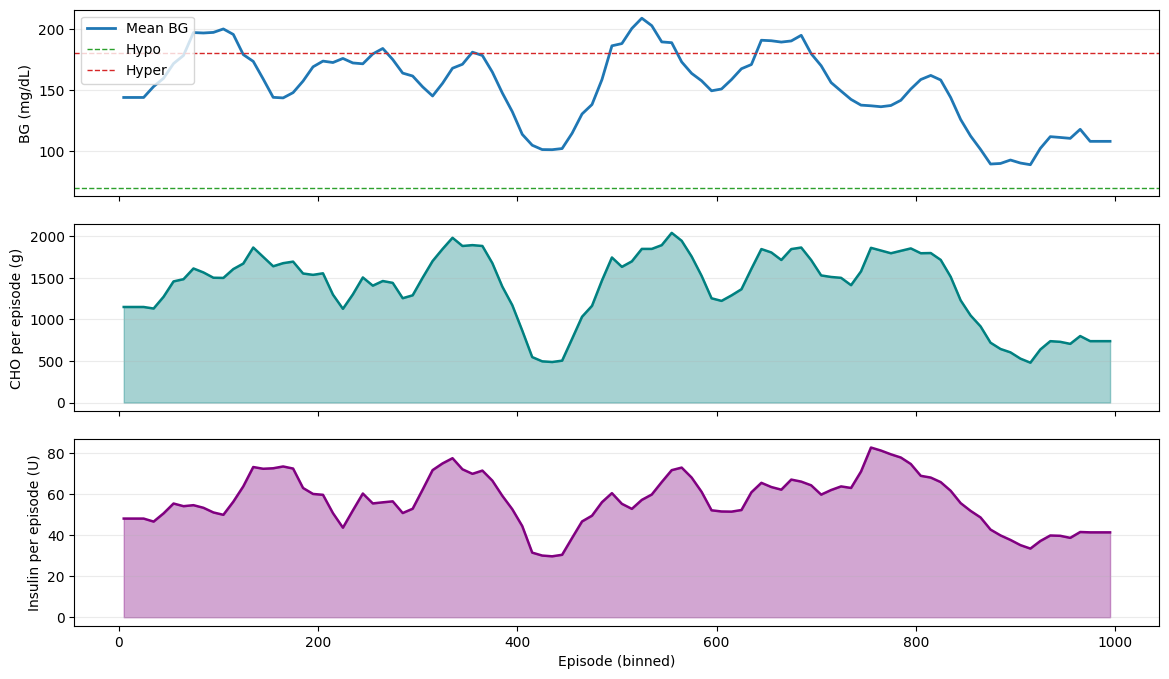

In [ ]:
plot_by_episode_compact(
    all_bg_per_episode,
    all_meal_per_episode,
    all_insulin_per_episode,
    sample_minutes=5,
    bins=100,     
    smooth=5,     
    clip_pct=99   
)



/tmp/ipython-input-2659571709.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


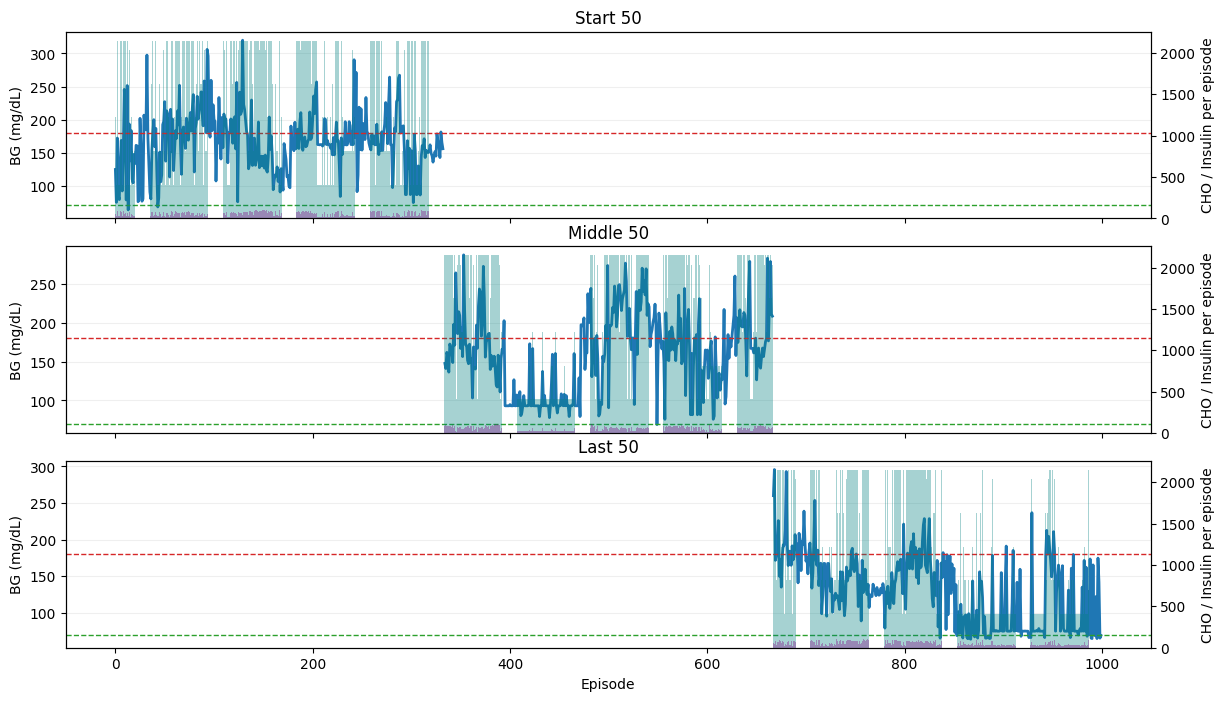

In [ ]:
plot_episode_windows(
    all_bg_per_episode,
    all_meal_per_episode,
    all_insulin_per_episode,
    sample_minutes=5,
    window_size=333   
)


/tmp/ipython-input-4042638718.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


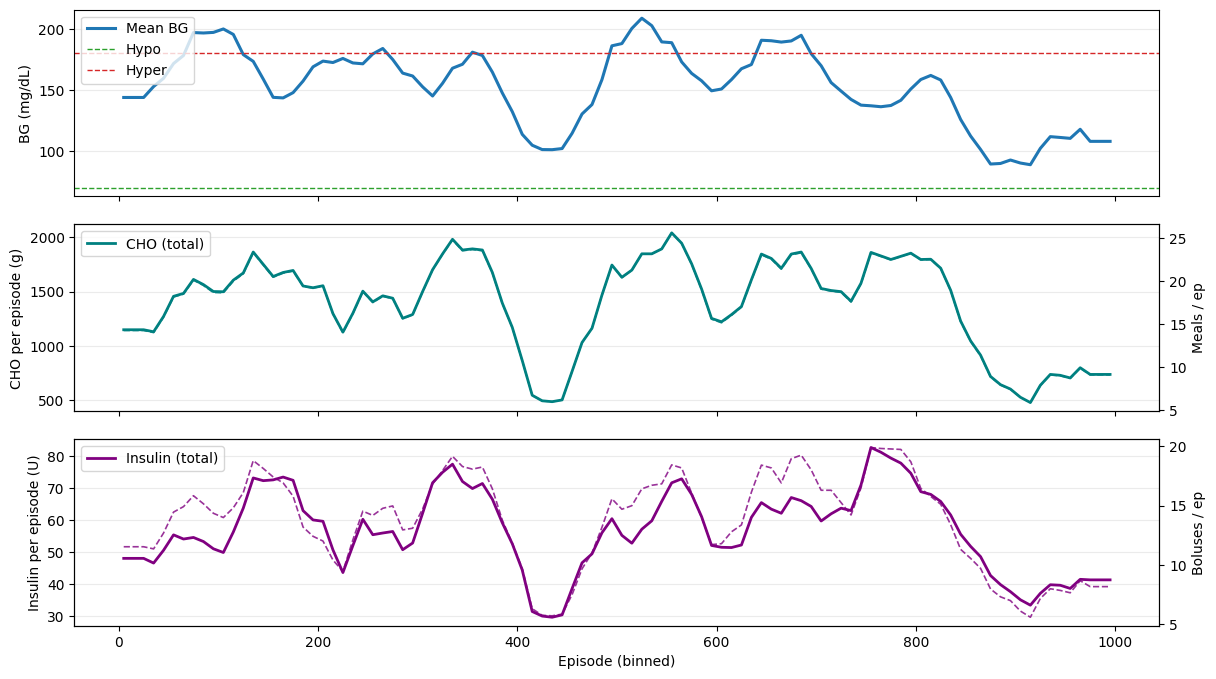

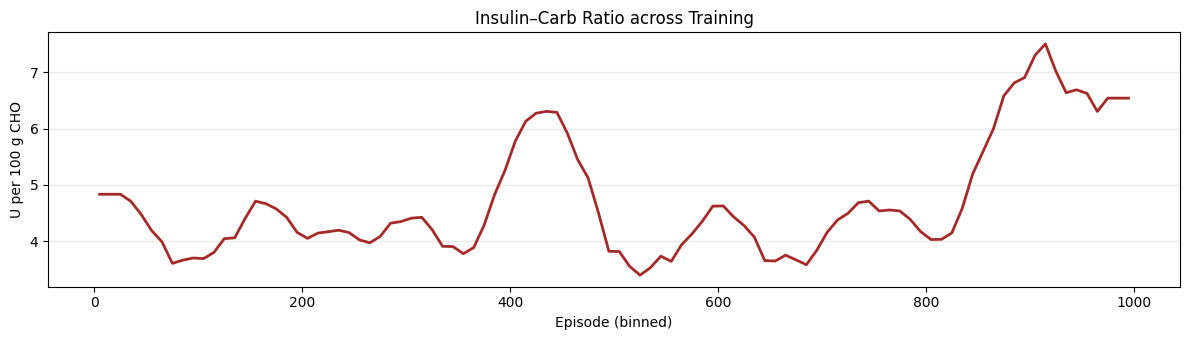

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _nanmean(a):
    return np.nan if len(a)==0 else np.nanmean(a)

def _bin_aggregate(values, bins):
    E = len(values)
    if E == 0:
        return np.array([]), np.array([])
    ep = np.arange(E)
    bidx = np.clip((ep * bins // max(E,1)).astype(int), 0, bins-1)
    agg = np.zeros(bins, float)
    for b in range(bins):
        m = (bidx == b)
        agg[b] = _nanmean(values[m])
    centers = (np.arange(bins) + 0.5) * (E / bins)
    return centers, agg

def _moving_avg(x, w):
    if w <= 1 or len(x) == 0:
        return x
    k = min(w, len(x))
    c = np.convolve(np.nan_to_num(x, nan=0.0), np.ones(k), 'valid') / k
    padL = (len(x) - len(c)) // 2
    padR = len(x) - len(c) - padL
    return np.pad(c, (padL, padR), mode='edge')

def _clip_pct(x, p):
    if len(x)==0 or np.all(np.isnan(x)):
        return x
    hi = np.nanpercentile(x, p)
    return np.minimum(x, hi)

def _count_starts(per_step):
    
    cnt = []
    for seq in per_step:
        s = np.asarray(seq, float)
        starts = np.sum((s > 0) & (np.r_[0.0, s[:-1]] <= 0))
        cnt.append(starts)
    return np.array(cnt, int)

def plot_by_episode_lines(
    all_bg, all_meal, all_ins, sample_minutes=5,
    bins=100, smooth=5, clip_pct=99, cho_thresh_for_ratio=30
):
    E = min(len(all_bg), len(all_meal), len(all_ins))
    if E == 0:
        raise ValueError("No episodes to plot.")

    # per-episode aggregates
    mean_bg   = np.array([np.mean(all_bg[i]) if len(all_bg[i]) else np.nan for i in range(E)])
    tir_pct   = np.array([np.mean((np.array(all_bg[i])>=70)&(np.array(all_bg[i])<=180))*100
                          if len(all_bg[i]) else np.nan for i in range(E)])
    cho_total = np.array([np.sum(all_meal[i])*sample_minutes if len(all_meal[i]) else 0.0 for i in range(E)])
    ins_total = np.array([np.sum(all_ins[i]) if len(all_ins[i]) else 0.0 for i in range(E)])
    meal_cnt  = _count_starts(all_meal)      
    bolus_cnt = _count_starts(all_ins)        

    # I:C ratio (U per 100 g CHO)
    ic = np.full(E, np.nan, float)
    mask = cho_total >= cho_thresh_for_ratio
    ic[mask] = ins_total[mask] / (cho_total[mask] / 100.0)

   
    cho_total = _clip_pct(cho_total, clip_pct)
    ins_total = _clip_pct(ins_total, clip_pct)

    # bin + smooth
    x,  y_bg   = _bin_aggregate(mean_bg, bins);   y_bg   = _moving_avg(y_bg, smooth)
    _,  y_tir  = _bin_aggregate(tir_pct, bins);   y_tir  = _moving_avg(y_tir, smooth)
    xc, y_cho  = _bin_aggregate(cho_total, bins); y_cho  = _moving_avg(y_cho, smooth)
    xi, y_ins  = _bin_aggregate(ins_total, bins); y_ins  = _moving_avg(y_ins, smooth)
    _,  y_mcnt = _bin_aggregate(meal_cnt, bins);  y_mcnt = _moving_avg(y_mcnt, smooth)
    _,  y_bcnt = _bin_aggregate(bolus_cnt, bins); y_bcnt = _moving_avg(y_bcnt, smooth)
    xr, y_ic   = _bin_aggregate(ic, bins);        y_ic   = _moving_avg(y_ic, smooth)

  
    fig, (ax_bg, ax_cho, ax_ins) = plt.subplots(
        3,1, figsize=(14,8), sharex=True, gridspec_kw={'hspace':0.15}
    )

    
    ax_bg.plot(x, y_bg, lw=2.2, label="Mean BG", color='C0')
    ax_bg.axhline(70,  ls='--', c='tab:green', lw=1, label="Hypo")
    ax_bg.axhline(180, ls='--', c='tab:red',   lw=1, label="Hyper")
    ax_bg.set_ylabel("BG (mg/dL)")
    ax_bg.grid(True, axis='y', alpha=0.25)
    ax_bg.legend(loc="upper left")
    

    
    ax_cho.plot(xc, y_cho, color='teal', lw=2.0, label="CHO (total)")
    ax_cho.set_ylabel("CHO per episode (g)")
    ax_cho.grid(True, axis='y', alpha=0.25)
    ax_cho.legend(loc="upper left")
    ax_cho_r = ax_cho.twinx()
    ax_cho_r.plot(x, y_mcnt, color='teal', lw=1.2, ls='--', alpha=0.8, label="# meals")
    ax_cho_r.set_ylabel("Meals / ep")

    
    ax_ins.plot(xi, y_ins, color='purple', lw=2.0, label="Insulin (total)")
    ax_ins.set_ylabel("Insulin per episode (U)")
    ax_ins.grid(True, axis='y', alpha=0.25)
    ax_ins.legend(loc="upper left")
    ax_ins_r = ax_ins.twinx()
    ax_ins_r.plot(x, y_bcnt, color='purple', lw=1.2, ls='--', alpha=0.8, label="# boluses")
    ax_ins_r.set_ylabel("Boluses / ep")

    
    E_full = len(all_bg)
    xticks = np.linspace(0, E_full, num=6, dtype=int)
    ax_ins.set_xticks(xticks)
    ax_ins.set_xticklabels([str(t) for t in xticks])
    ax_ins.set_xlabel("Episode (binned)")

    plt.tight_layout()
    plt.show()

    
    plt.figure(figsize=(12,3.5))
    plt.plot(xr, y_ic, color='brown', lw=2)
    plt.ylabel("U per 100 g CHO")
    plt.xlabel("Episode (binned)")
    plt.title("Insulin–Carb Ratio across Training")
    plt.grid(True, axis='y', alpha=0.25)
    plt.tight_layout()
    plt.show()


plot_by_episode_lines(
    all_bg_per_episode, all_meal_per_episode, all_insulin_per_episode,
    sample_minutes=5, bins=100, smooth=5, clip_pct=99
)
